In [94]:
#import the relevant configuration file
from configfiles import fieldYconfig as fieldconfig 
#from configfiles import Hnorthconfig as fieldconfig 
#from configfiles import archSEconfig as fieldconfig 
fieldconfig.bkgbox

13

In [95]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt
import subprocess

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord,Angle 
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord,skycoord_to_pixel
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join


from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry, CircularAperture
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

from regions import read_ds9, write_ds9, CircleSkyRegion
import re

In [96]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(fieldconfig.dpath)
except:
    os.chdir(fieldconfig.dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fieldconfig.fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

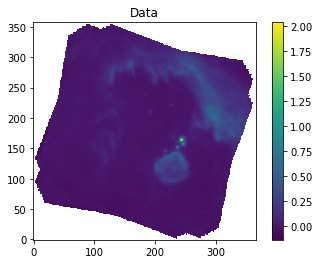

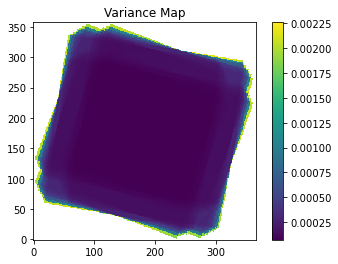

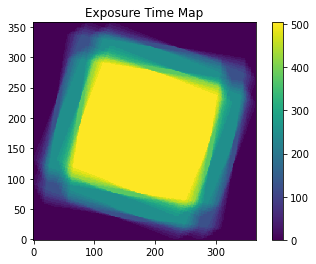

In [97]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

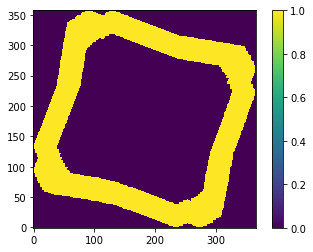

In [98]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<fieldconfig.tmapnormcut,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed
#the above can be adjusted if there are obvious sources near the edges of the map

#plot any of the mask to verify
plt.figure()
plt.imshow(mask,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [99]:
#create background model for image using median method
bkg_estimator = MedianBackground() #MMMBackground() #SExtractorBackground() #MedianBackground()
bkg_data = Background2D(data,(fieldconfig.bkgbox, fieldconfig.bkgbox), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

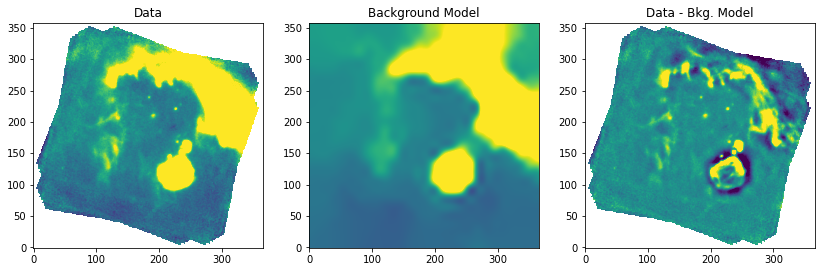

In [100]:
#plot the data and background model
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(14,10))
ax1.set_title('Data')

#set the image limits for the plots
minval=-0.1
maxval=0.1

ax1.imshow(data,origin='lower',vmin=minval,vmax=maxval)
ax2.set_title('Background Model')
ax2.imshow(bkg,origin='lower',vmin=minval,vmax=maxval)
ax3.set_title('Data - Bkg. Model')
ax3.imshow(data_bkgsub,origin='lower',vmin=minval,vmax=maxval)
plt.show()

In [101]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

#removed labels that exist in masked region
if fieldconfig.usemask2:
    mask2=np.zeros(np.shape(mask))
    for lim in fieldconfig.m2limits:
        mask2[lim[0]:lim[1],lim[2]:lim[3]]=1
    segm.remove_masked_labels(mask2.astype('bool'))

In [102]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3) 
if fieldconfig.usemask3:
    mask3=np.zeros(np.shape(mask))
    for lim in fieldconfig.m3limits:
        mask3[lim[0]:lim[1],lim[2]:lim[3]]=1
    segm_deblend.remove_masked_labels(mask3.astype('bool'))

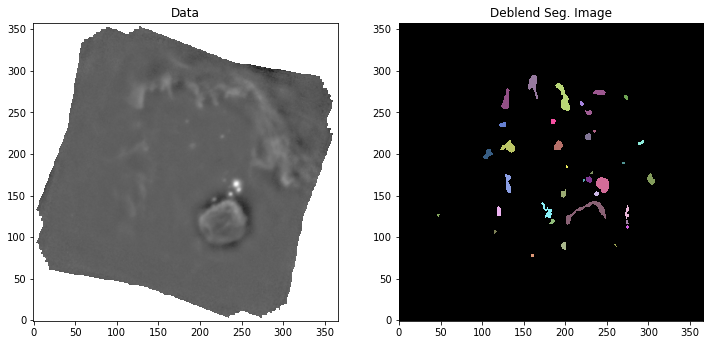

In [103]:
#make plot of segmentation image to show detected sources side by side with data
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Deblend Seg. Image')
plt.show()

In [104]:
#now lets look at building a catalog from the deblended segmentation map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [105]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#change format of columns to save fewer decimal places
for col in tbl2.colnames:
    if col!='sky_centroid': #skip sky centroid since its problematic in this context
        tbl2[col].info.format = '%.4G'
    
#display table
tbl2

C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,159.6,77.95,"266.5800251475193,-28.843731627433662",-0.005775,-0.02641,-0.2905,11,1.093,0.7544,19.77,0.9422,-0.5859,1.652,0.7237,0.3099,1.449,2.212,1.214,0.1366,3.319,0.2487,0.03331,-0.0264,-0.02637,0.0001881,1.363
2,259.4,90.06,"266.55572621294203,-28.84114756128228",0.002926,-0.04902,-0.2941,6,1.232,0.3392,-40.28,4.018,7.925,5.334,0.9613,0.7246,3.631,2.127,0.5668,0.08708,3.338,0.1354,0.02216,-0.04898,-0.04915,0.0005713,0.9097
3,115,106.9,"266.590888100167,-28.837551882716653",0.0008156,-0.01252,-0.1252,10,1.104,0.7762,38.11,1.14,-0.8153,1.34,0.7111,0.2969,1.422,2.247,3.333,0.1319,3.622,0.3115,0.02787,-0.01294,-0.01309,0.001715,1.866
4,274.1,112.5,"266.5521503045398,-28.836356419461502",0.03695,-0.04065,-0.3252,8,0.9009,0.6367,-86.79,2.463,0.1379,1.236,0.7074,0.2932,1.415,1.837,1.135,0.1123,3.43,0.1629,0.02748,-0.04054,-0.04058,0.0005849,0.9828
5,183.3,118.3,"266.5742503642592,-28.83511949786837",0.02451,-0.006173,-0.1667,27,1.841,1.079,46.23,0.5894,-0.5637,0.5651,0.8103,0.414,1.706,3.552,1.353,0.09864,1.821,0.6176,0.04505,-0.0059,-0.007151,0.002934,2.91
6,273.6,118.2,"266.5522640262538,-28.835136349451307",0.04572,-0.03701,-0.3331,9,1.11,0.6143,-77.04,2.558,0.8038,0.9034,0.8331,0.4468,1.808,2.113,0.7975,0.1132,3.29,0.1328,0.02859,-0.03696,-0.03688,0.0007895,0.7852
7,46.62,126.7,"266.607545241809,-28.83331938688373",-0.04022,-0.01877,-0.1502,8,0.8555,0.5788,-80.63,2.942,0.5199,1.409,0.7364,0.3235,1.478,1.72,0.6872,0.09976,2.614,0.2859,0.03425,-0.01896,-0.01895,0.00051,1.545
8,119.8,130.9,"266.5897362728452,-28.832443754368867",-0.005786,0.02145,1.073,50,3.081,1.262,-85.41,0.6246,0.0834,0.1087,0.9123,0.5904,2.441,5.544,10.03,0.2209,2.868,2.94,0.06237,0.02141,0.02178,0.001927,2.74


In [106]:
#write out the resulting table to file
ascii.write(tbl2, fieldconfig.field+'_25um_seg.dat', overwrite=True)

Now lets try another other source detection method for comparison

In [107]:
from photutils import DAOStarFinder,IRAFStarFinder

In [108]:
#do statistics on image - daofind requires a single value for threshold rather than a 2d map
mean, median, std = sigma_clipped_stats(data_bkgsub, sigma=3.0)  
print('Data mean, med, std: ',(mean, median, std))  

print('Seg. Threshold mean/median comparison: ', (np.mean(threshold)/3.,np.median(threshold)/3.))

Data mean, med, std:  (-0.002232576418788897, -0.0016300109282545898, 0.019078643838796237)
Seg. Threshold mean/median comparison:  (0.017126377184120887, 0.0115284062279251)


In [109]:
#now run starfinder to find sources 
daofind = DAOStarFinder(fwhm=4.2, threshold=3*std)
DAOsources = daofind(data_bkgsub,mask=mask)

StarFinder = IRAFStarFinder(fwhm=4.2, threshold=3*std)
IRAFsources = StarFinder(data_bkgsub,mask=mask)

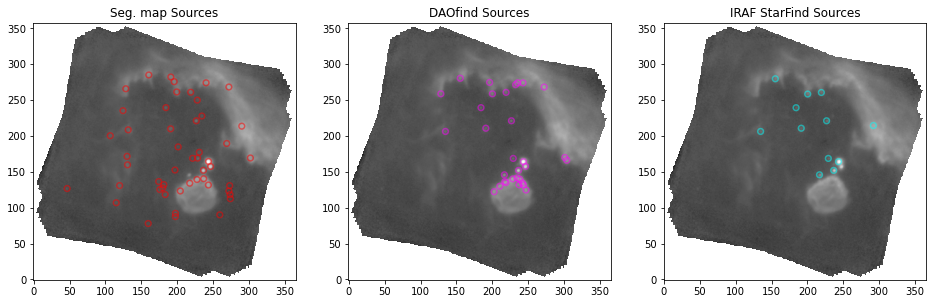

In [110]:
#plot data with apertures on detected sources
Dpositions = np.transpose((DAOsources['xcentroid'], DAOsources['ycentroid']))
Dapertures = CircularAperture(Dpositions, r=4.)
Ipositions = np.transpose((IRAFsources['xcentroid'], IRAFsources['ycentroid']))
Iapertures = CircularAperture(Ipositions, r=4.)
Spositions = np.transpose((tbl2['xcentroid'], tbl2['ycentroid']))
Sapertures = CircularAperture(Spositions, r=4.)

norm = ImageNormalize(stretch=SqrtStretch())

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 10))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Seg. map Sources')
Sapertures.plot(color='red', lw=1.5, alpha=0.5,axes=ax1)

ax2.imshow(data, origin='lower', cmap='Greys_r',norm=norm)
ax2.set_title('DAOfind Sources')
Dapertures.plot(color='magenta', lw=1.5, alpha=0.5,axes=ax2)

ax3.imshow(data, origin='lower', cmap='Greys_r',norm=norm)
ax3.set_title('IRAF StarFind Sources')
Iapertures.plot(color='cyan', lw=1.5, alpha=0.5,axes=ax3)

plt.show()

In [111]:
#lets add ra, dec coordinates of sources to DAOsources table
Nsources=len(DAOsources['id'])
scs=[]

for i in range(0,Nsources):
    xcoord=DAOsources['xcentroid'][i]
    ycoord=DAOsources['ycentroid'][i]
    sc=pixel_to_skycoord(xcoord,ycoord,wcsmap)
    scs.append(sc)
    
DAOsources['sky_centroid']=scs

#change format of columns to save fewer decimal places
for col in DAOsources.colnames:
    if col!='sky_centroid': #skip sky centroid since its problematic in this context
        DAOsources[col].info.format = '%.4G'

#pring DAO sources table?
#DAOsources

In [112]:
#write out the resulting table to file
ascii.write(DAOsources, fieldconfig.field+'_25um_dao.dat', overwrite=True)

In [113]:
#create ds9 regions file for segmentation map sources
#start by getting lists of coords from table
sourcecoords=tbl2['sky_centroid']

#set size of regions 
radius = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"

#loop through and create region instances for each source
regions=[]
for i in range(0,len(sourcecoords)):
    region = CircleSkyRegion(sourcecoords[i], radius)
    regions.append(region)
    
#write out region file
write_ds9(regions, fieldconfig.field+'_seg.reg')


In [114]:
#change the color of the regions to red - no built in way to do this in regions package :-/
with open(fieldconfig.field+'_seg.reg', 'r+') as f:
    text = f.read()
    text = re.sub(r'\)', r') # color=red', text)
    f.seek(0)
    f.write(text)
    f.truncate()

In [115]:
#create ds9 region file for DAO sources

sourcecoords=DAOsources['sky_centroid']

regions=[]
for i in range(0,len(sourcecoords)):
    region = CircleSkyRegion(sourcecoords[i], radius)
    regions.append(region)
    
#write out region file
write_ds9(regions, fieldconfig.field+'_DF.reg')

In [116]:
#change the color of the regions to cyan - no built in way to do this in regions package :-/
with open(fieldconfig.field+'_DF.reg', 'r+') as f:
    text2 = f.read()
    text2 = re.sub(r'\)', r') # color=cyan', text2)
    f.seek(0)
    f.write(text2)
    f.truncate()

In [117]:
#create new region file including both sets of sources
newregtext=text+text2[45:]

with open(fieldconfig.field+'.reg', 'w+') as f:
    f.seek(0)
    f.write(newregtext)
    f.truncate()

In [118]:
#open ds9 and load in the region file that was just saved. Note that you may be able to just run 'ds9' here if bash is set up correctly
ds9path='C:\\Users\\mhankins1\\'
subprocess.Popen(ds9path+'ds9.exe '+fieldconfig.fname+ ' -mode region -regions load '+fieldconfig.field+'.reg') 

#note if you're using a linux machine you may be able to run ds9 using the command below without specifying the full path to ds9. 
#subprocess.Popen('ds9 '+fname+ ' -mode region -regions load '+field+'.reg',shell=True) 

In [119]:
#delete any regions for any spurious detections...
#add new regions for any sources that appear to be missed...
#save new region file as field+'_update.reg'

In [120]:
#this can be used to read the regions file back in after modification
#load in sources from region file. Option to use original regions or a new regions file
#regfile=field+'.reg'
#regfile=fieldconfig.field+'_update.reg'

#new_regions = read_ds9(regfile)

In [121]:
#new_regions